In [1]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import random
from PIL import Image
import torch
import torchvision.transforms as transforms

# Custom Dataset Class with Stratified Sampling
class AlzheimerDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
        self.images = []
        self.labels = []

        # Collecting the file paths for each class
        class_files = {class_name: [] for class_name in self.classes}
        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.endswith('.jpg'):
                    class_files[class_name].append((os.path.join(class_dir, file), idx))

        
        class_counts = {  
            'Mild_Demented': 896,
            'Moderate_Demented': 64,
            'Non_Demented': 3200,
            'Very_Mild_Demented': 2240
        }
        max_class = 'Non_Demented'
        max_class_size = class_counts[max_class]  # 3200

        balanced_data = []
        for class_name, files in class_files.items():
            if class_counts[class_name] < max_class_size:  # Oversample
                balanced_data += resample(files, replace=True, n_samples=max_class_size, random_state=42)
            else:
                balanced_data += resample(files, replace=False, n_samples=max_class_size, random_state=42)

        # Shuffle and extract images/labels
        random.shuffle(balanced_data)
        images, labels = zip(*balanced_data)

        # Perform stratified split based on class labels
        train_images, test_images, train_labels, test_labels = train_test_split(
            images, labels, test_size=0.2, stratify=labels, random_state=42
        )

        if train:
            self.data = list(zip(train_images, train_labels))
        else:
            self.data = list(zip(test_images, test_labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [2]:
# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Dataset
root_dir = '/Users/r1shi_y/Desktop/Desktop/Dataset'
train_dataset = AlzheimerDataset(root_dir=root_dir, transform=transform, train=True)
test_dataset = AlzheimerDataset(root_dir=root_dir, transform=transform, train=False)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [3]:
import torch.nn as nn

class EnhancedNeuralNetwork(nn.Module):
    def __init__(self):
        super(EnhancedNeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)  
        )
    
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedNeuralNetwork().to(device)
print(model)


EnhancedNeuralNetwork(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [4]:
class_weights = [1.0 / 896, 1.0 / 64, 1.0 / 3200, 1.0 / 2240]
class_weights = torch.FloatTensor(class_weights).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [5]:
# Training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0 or batch == len(dataloader) - 1:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():  # Disable gradient computation for testing
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)  # Move inputs to device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # Count correct predictions

    # Calculate average loss and accuracy
    test_loss /= num_batches
    correct /= size
    accuracy = correct  # Accuracy as a fraction between 0 and 1

    print(f"Test Error: \n Accuracy: {(100 * accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return accuracy  # Return accuracy for comparison in training loop



In [7]:
epochs = 25
best_accuracy = 0.0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test_accuracy = test(test_loader, model, loss_fn)  # This now returns the accuracy
    
    # Save the best model if the current test accuracy is better
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "best_alzheimers_model.pth")
        print(f"Saved best model with accuracy: {100 * best_accuracy:.2f}%")

print("Training complete!")


Epoch 1
-------------------------------


KeyboardInterrupt: 

In [6]:
model = EnhancedNeuralNetwork().to(device)
model.load_state_dict(torch.load("best_alzheimers_model.pth"))
model.eval()

# Evaluation on test images
classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
test_images, test_labels = zip(*test_dataset.data)
test_images = list(test_images)
test_labels = list(test_labels)

with torch.no_grad():
    for i in range(200):  # Test on first 200 images
        img_path = test_images[i]
        img = Image.open(img_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)
        pred = model(img)
        predicted, actual = classes[pred.argmax(1).item()], classes[test_labels[i]]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')


/var/folders/4f/386q01l131s09hhhcny7x8w00000gn/T/ipykernel_3849/486938243.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_alzheime

Predicted: "Very_Mild_Demented", Actual: "Non_Demented"
Predicted: "Very_Mild_Demented", Actual: "Very_Mild_Demented"
Predicted: "Moderate_Demented", Actual: "Moderate_Demented"
Predicted: "Mild_Demented", Actual: "Non_Demented"
Predicted: "Non_Demented", Actual: "Non_Demented"
Predicted: "Non_Demented", Actual: "Non_Demented"
Predicted: "Very_Mild_Demented", Actual: "Non_Demented"
Predicted: "Very_Mild_Demented", Actual: "Very_Mild_Demented"
Predicted: "Mild_Demented", Actual: "Non_Demented"
Predicted: "Very_Mild_Demented", Actual: "Very_Mild_Demented"
Predicted: "Mild_Demented", Actual: "Mild_Demented"
Predicted: "Mild_Demented", Actual: "Mild_Demented"
Predicted: "Moderate_Demented", Actual: "Moderate_Demented"
Predicted: "Very_Mild_Demented", Actual: "Very_Mild_Demented"
Predicted: "Very_Mild_Demented", Actual: "Very_Mild_Demented"
Predicted: "Non_Demented", Actual: "Non_Demented"
Predicted: "Very_Mild_Demented", Actual: "Very_Mild_Demented"
Predicted: "Very_Mild_Demented", Actual:

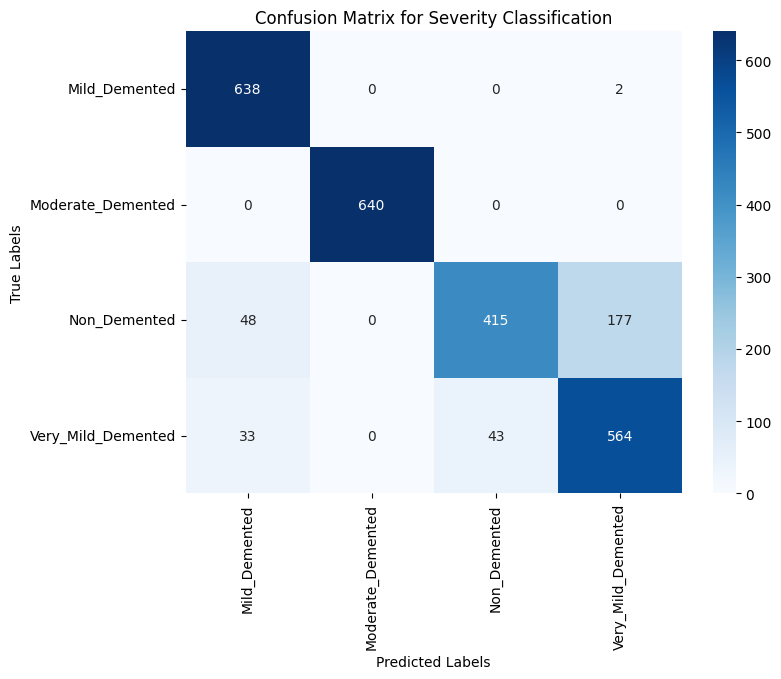

Confusion Matrix:
[[638   0   0   2]
 [  0 640   0   0]
 [ 48   0 415 177]
 [ 33   0  43 564]]
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.89      1.00      0.94       640
 Moderate_Demented       1.00      1.00      1.00       640
      Non_Demented       0.91      0.65      0.76       640
Very_Mild_Demented       0.76      0.88      0.82       640

          accuracy                           0.88      2560
         macro avg       0.89      0.88      0.88      2560
      weighted avg       0.89      0.88      0.88      2560



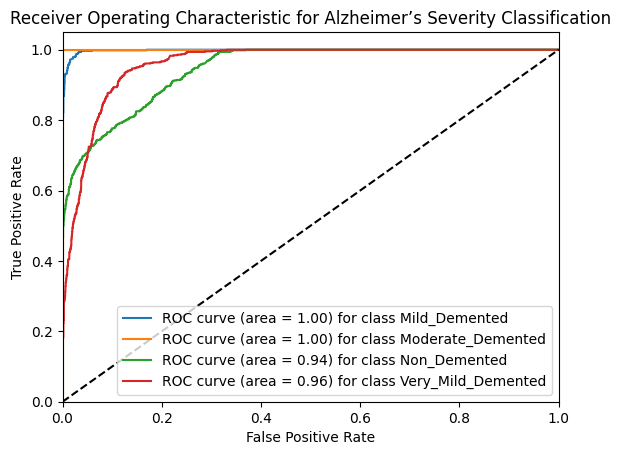

In [10]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming the following:
# `model`: Your trained model
# `test_loader`: Your DataLoader for the test dataset
# `device`: Your computation device (CPU/GPU)
# `classes`: A list of class names, e.g., ['Nondemented', 'Very mildly demented', 'Mildly demented', 'Moderately demented']

# Ensure model is in evaluation mode
model.eval()

# Initialize lists to collect actual and predicted labels
all_labels = []
all_preds = []
all_probs = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Store actual labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Softmax for probabilities

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Confusion Matrix with labels
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Severity Classification')
plt.show()

# Print Confusion Matrix as text
print("Confusion Matrix:")
print(cm)

# Classification Report: Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# ROC Curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# One-vs-rest for multiclass ROC and AUC
n_classes = len(classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {classes[i]}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Alzheimer’s Severity Classification')
plt.legend(loc="lower right")
plt.show()



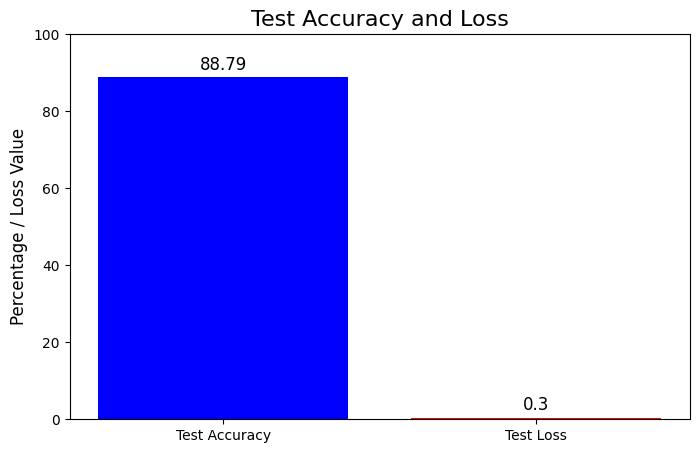

In [7]:
import matplotlib.pyplot as plt

# Data for visualization
metrics = ['Test Accuracy', 'Test Loss']
values = [88.79, 0.295726]

# Create a simple bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'red'])

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Add titles and labels
plt.title('Test Accuracy and Loss', fontsize=16)
plt.ylabel('Percentage / Loss Value', fontsize=12)
plt.ylim(0, 100)  # Limit y-axis to 100 to fit the accuracy scale

# Display the chart
plt.show()


In [8]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to extract features from the CNN
def extract_features(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    features = []
    
    with torch.no_grad():  # Disable gradient calculation
        for data, _ in data_loader:
            data = data.to(device)
            # Extract features from the model (before the final fully connected layer)
            output = model.model[:-3](data)  # Remove the last 3 layers to get the feature output
            features.append(output.cpu().numpy())
    
    # Stack features into a matrix
    return np.vstack(features)

# Example usage
features = extract_features(model, test_loader, device)


In [1]:
# Calculate the Pearson correlation matrix
correlation_matrix = np.corrcoef(features, rowvar=False)

# Visualize the Pearson correlation matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False)
plt.title('Pearson Correlation Heatmap of CNN Features', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


NameError: name 'np' is not defined

SyntaxError: invalid syntax (760677887.py, line 1)